In [205]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Dataset Generation


In [206]:
def generateDataset(N, seq_len_range=(2, 9)):
    X = []
    Y = []
    for i in range(N):
        seq_len = np.random.randint(seq_len_range[0], seq_len_range[1]+1)
        X_num = np.random.uniform(low=0, high=1, size=(seq_len, 1))
        X_mask = np.zeros((seq_len, 1))
        positions = np.random.choice(seq_len, size=2, replace=False)
        X_mask[positions] = 1
        Y.append(np.sum(X_num[positions]))
        X.append(np.concatenate([X_num, X_mask], axis=1))
    X = np.asarray(X)
    Y = np.asarray(Y).reshape(-1, 1)
    return X, Y

In [207]:
X_train, Y_train = generateDataset(4000)
X_test, Y_test = generateDataset(1000,seq_len_range=(7,12))

<ipython-input-206-d4c7eeb8865a>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.asarray(X)


In [208]:
X_train = pad_sequences(X_train, padding='post', dtype=np.float32)
X_test = pad_sequences(X_test, padding='post', dtype=np.float32)

In [209]:
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train_tf = tf.convert_to_tensor(Y_train, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test_tf = tf.convert_to_tensor(Y_test, dtype=tf.float32)

# Simple RNN 

In [210]:
class SimpleRNNLayer(tf.keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.U = self.add_weight(shape=(input_dim, self.units),
                                 initializer='glorot_uniform',
                                 name='U')
        self.W = self.add_weight(shape=(self.units, self.units),
                                 initializer='orthogonal',
                                 name='W')
        self.bias_x = self.add_weight(shape=(self.units,),
                                      initializer='zeros',
                                      name='bias_x')
        self.bias_y = self.add_weight(shape=(1,),
                                      initializer='zeros',
                                      name='bias_y')
        self.built = True

    def call(self, inputs, mask=None):
        # Initialize hidden state
        batch_size = tf.shape(inputs)[0]
        h0 = tf.zeros((batch_size, self.units), dtype=inputs.dtype)

        # Loop over time steps and compute hidden states
        ht = h0
        for i in range(tf.shape(inputs)[1]):
            xt = inputs[:, i, :]
            ht = self.activation(tf.matmul(xt, self.U) + tf.matmul(ht, self.W) + self.bias_x)

        # Compute output
        output = tf.matmul(ht, tf.transpose(self.W)) + self.bias_y
        return output

In [211]:
def elmon_model():
    model = Sequential()
    model.add(SimpleRNNLayer(32, activation='tanh'))
    return model

elmon = elmon_model()
elmon.compile(loss='mean_squared_error', optimizer='adam')
elmon_history = elmon.fit(X_train_tf, Y_train_tf, epochs=50,verbose = 0)


# LSTM

In [212]:
class LSTMLayer(tf.keras.layers.Layer):
    def __init__(self, units, input_shape=None):
        super().__init__()
        self.units = units
        self.input_shape_ = input_shape

        if input_shape is not None:
            self.build(input_shape)
    
    def build(self, input_shape):
        self.input_dim = input_shape[-1]

        self.w_i = self.add_weight(shape=(self.input_dim, self.units), name="input_weight")
        self.w_h = self.add_weight(shape=(self.units, self.units), name="recurrent_weight")
        self.b = self.add_weight(shape=(self.units,), name="bias")

        self.w_f = self.add_weight(shape=(self.input_dim, self.units), name="forget_weight")
        self.w_o = self.add_weight(shape=(self.input_dim, self.units), name="output_weight")
        self.w_c = self.add_weight(shape=(self.input_dim, self.units), name="cell_weight")

        self.w_hf = self.add_weight(shape=(self.units, self.units), name="recurrent_forget_weight")
        self.w_ho = self.add_weight(shape=(self.units, self.units), name="recurrent_output_weight")
        self.w_hc = self.add_weight(shape=(self.units, self.units), name="recurrent_cell_weight")

    def call(self, inputs):
        hidden_state = tf.zeros((tf.shape(inputs)[0], self.units))
        cell_state = tf.zeros((tf.shape(inputs)[0], self.units))

        for i in range(inputs.shape[1]):
            x_t = inputs[:, i, :]

            forget_gate = tf.sigmoid(tf.matmul(x_t, self.w_f) + tf.matmul(hidden_state, self.w_hf))
            input_gate = tf.sigmoid(tf.matmul(x_t, self.w_i) + tf.matmul(hidden_state, self.w_h))
            output_gate = tf.sigmoid(tf.matmul(x_t, self.w_o) + tf.matmul(hidden_state, self.w_ho))

            candidate_cell_state = tf.tanh(tf.matmul(x_t, self.w_c) + tf.matmul(hidden_state, self.w_hc))
            cell_state = forget_gate * cell_state + input_gate * candidate_cell_state
            hidden_state = output_gate * tf.tanh(cell_state)

        return hidden_state

In [213]:
def lstm_model():
    model = Sequential()
    model.add(LSTMLayer(32, input_shape=(None, 2)))
    return model

lstm = lstm_model()
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm_history = lstm.fit(X_train_tf, Y_train_tf, epochs=50,verbose = 0)

# GRU

In [214]:
class GRULayer(tf.keras.layers.Layer):
    def __init__(self, units, input_shape=None):
        super().__init__()
        self.units = units
        self.input_shape_ = input_shape

        if input_shape is not None:
            self.build(input_shape)

    def build(self, input_shape):
        self.input_dim = input_shape[-1]

        self.w_z = self.add_weight(shape=(self.input_dim, self.units), name="update_weight")
        self.w_r = self.add_weight(shape=(self.input_dim, self.units), name="reset_weight")
        self.w_h = self.add_weight(shape=(self.input_dim, self.units), name="new_hidden_weight")
        self.b_z = self.add_weight(shape=(self.units,), name="update_bias")
        self.b_r = self.add_weight(shape=(self.units,), name="reset_bias")
        self.b_h = self.add_weight(shape=(self.units,), name="new_hidden_bias")

        self.w_hz = self.add_weight(shape=(self.units, self.units), name="recurrent_update_weight")
        self.w_hr = self.add_weight(shape=(self.units, self.units), name="recurrent_reset_weight")
        self.w_hh = self.add_weight(shape=(self.units, self.units), name="recurrent_new_hidden_weight")

    def call(self, inputs):
        hidden_state = tf.zeros((tf.shape(inputs)[0], self.units))

        for i in range(inputs.shape[1]):
            x_t = inputs[:, i, :]

            z_gate = tf.sigmoid(tf.matmul(x_t, self.w_z) + tf.matmul(hidden_state, self.w_hz) + self.b_z)
            r_gate = tf.sigmoid(tf.matmul(x_t, self.w_r) + tf.matmul(hidden_state, self.w_hr) + self.b_r)

            h_tilde = tf.tanh(tf.matmul(x_t, self.w_h) + tf.matmul(r_gate * hidden_state, self.w_hh) + self.b_h)

            hidden_state = (1 - z_gate) * hidden_state + z_gate * h_tilde

        return hidden_state

In [215]:
def gru_model():
    model = Sequential()
    model.add(GRULayer(32, input_shape=(None, 2)))
    return model

gru = gru_model()
gru.compile(loss='mean_squared_error', optimizer='adam')
gru_history = gru.fit(X_train_tf, Y_train_tf, epochs=50,verbose = 0)

# Baseline

In [216]:
baseline_loss = 0
mse = tf.keras.losses.MeanSquaredError()

for i in range(4000):
    x = tf.constant([1])
    y = Y_train[i]
    loss = mse(x, y)
    baseline_loss += loss

baseline_loss /= 4000
baseline_loss = tf.cast(baseline_loss, dtype=tf.float32)
x = tf.linspace(-1.0, 50, 50)
y = tf.ones(50) * baseline_loss

# learning curves

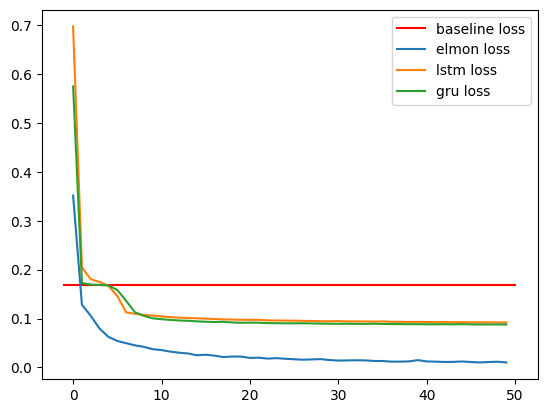

In [217]:
plt.plot(x, y, '-r', label='baseline loss')
plt.plot(elmon_history.history['loss'], label='elmon loss')
plt.plot(lstm_history.history['loss'], label='lstm loss')
plt.plot(gru_history.history['loss'], label='gru loss')
plt.legend()
plt.show()


# Evaluated Losses

In [218]:
evaluated_baseline_loss = 0
mse = tf.keras.losses.MeanSquaredError()

for i in range(1000):
    x = tf.constant([1])
    y = Y_test[i]
    loss = mse(x, y)
    evaluated_baseline_loss += loss

evaluated_baseline_loss /= 1000

evaluated_elmon_loss = elmon.evaluate(X_test, Y_test, verbose=0)
evaluated_lstm_loss = lstm.evaluate(X_test, Y_test, verbose=0)
evaluated_gru_loss = gru.evaluate(X_test, Y_test, verbose=0)

In [222]:
print('Evaluated Baseline loss:', evaluated_baseline_loss.numpy())
print('Evaluated Elmon loss:', evaluated_elmon_loss)
print('Evaluated LSTM loss:', evaluated_lstm_loss)
print('Evaluated GRU loss:', evaluated_gru_loss)

Evaluated Baseline loss: 0.17324050566656168
Evaluated Elmon loss: 0.36695119738578796
Evaluated LSTM loss: 0.15351596474647522
Evaluated GRU loss: 0.17323483526706696
